In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [2]:
def simulate_time_series(n_steps, seasonality_period, noise_level=0.1, seed=42):
    np.random.seed(seed)  # For reproducibility
    trend = np.linspace(0, 10, n_steps)
    seasonality = np.sin(np.linspace(0, 2 * np.pi * (n_steps / seasonality_period), n_steps))
    noise = np.random.normal(0, noise_level, n_steps)
    return trend + seasonality + noise

# Generate the time series data
n_steps = 5000
seasonality_period = 50
time_series_data = simulate_time_series(n_steps, seasonality_period)


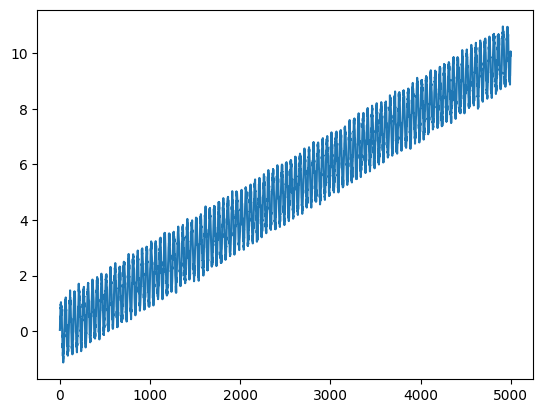

In [3]:
# Plot time series data
import matplotlib.pyplot as plt
plt.plot(time_series_data)
plt.show()


In [4]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(time_series_data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Differencing the data if p-value > 0.05 (non-stationary)
diff_data = np.diff(time_series_data)


ADF Statistic: -0.1441601463968344
p-value: 0.94485847892832


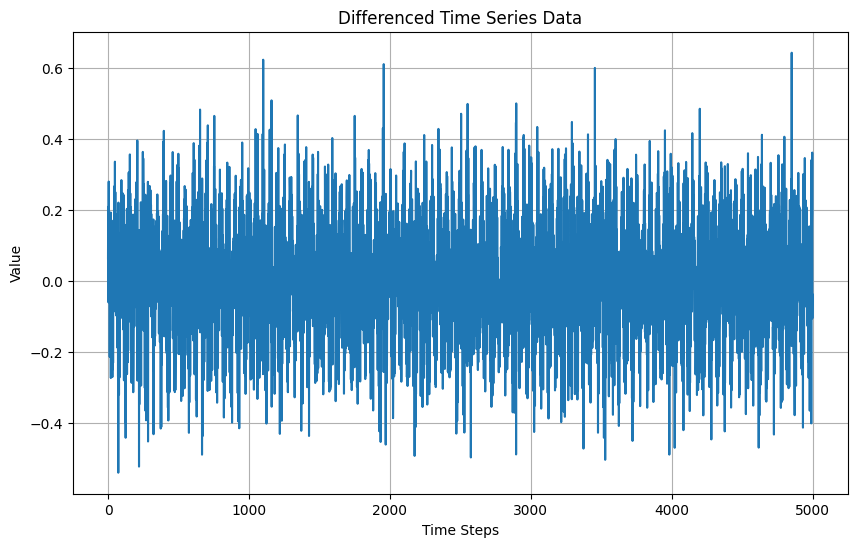

In [5]:
# PLot diff_data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(diff_data)
plt.title('Differenced Time Series Data')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [6]:
def create_sequences(data, n_steps_in, n_steps_out=1):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out])  # Slice for next step
    return np.array(X), np.array(y).reshape(-1, n_steps_out)  # Reshape y properly

# Generate sequences and targets from the differenced data
n_steps_in = 50  # Use last 50 steps to predict the next step
n_steps_out = 1  # Predict 1 step ahead

# Generate sequences from `diff_data`
X, y = create_sequences(diff_data, n_steps_in, n_steps_out)

# Now X and y should have the same number of samples
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (4949, 50), y shape: (4949, 1)


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training/validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Further split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=False)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(2)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [8]:
import torch
import torch.nn as nn

class JordanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(JordanRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.rnn = nn.RNN(input_size + 1, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        sequence_length = x.size(1)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        output = torch.zeros(batch_size, 1, 1).to(x.device)

        for t in range(sequence_length):
            combined_input = torch.cat((x[:, t:t+1, :], output), dim=2)
            out, h0 = self.rnn(combined_input, h0)
            output = self.fc(out)

        return output.squeeze(1)  # Return the final output


Epoch [5/100], Train Loss: 0.0290, Val Loss: 0.0303
Epoch [10/100], Train Loss: 0.0269, Val Loss: 0.0287
Epoch [15/100], Train Loss: 0.0265, Val Loss: 0.0279
Epoch [20/100], Train Loss: 0.0258, Val Loss: 0.0274
Epoch [25/100], Train Loss: 0.0246, Val Loss: 0.0261
Epoch [30/100], Train Loss: 0.0231, Val Loss: 0.0245
Epoch [35/100], Train Loss: 0.0220, Val Loss: 0.0233
Epoch [40/100], Train Loss: 0.0205, Val Loss: 0.0220
Epoch [45/100], Train Loss: 0.0199, Val Loss: 0.0213
Epoch [50/100], Train Loss: 0.0194, Val Loss: 0.0206
Epoch [55/100], Train Loss: 0.0188, Val Loss: 0.0202
Early stopping triggered at epoch 56


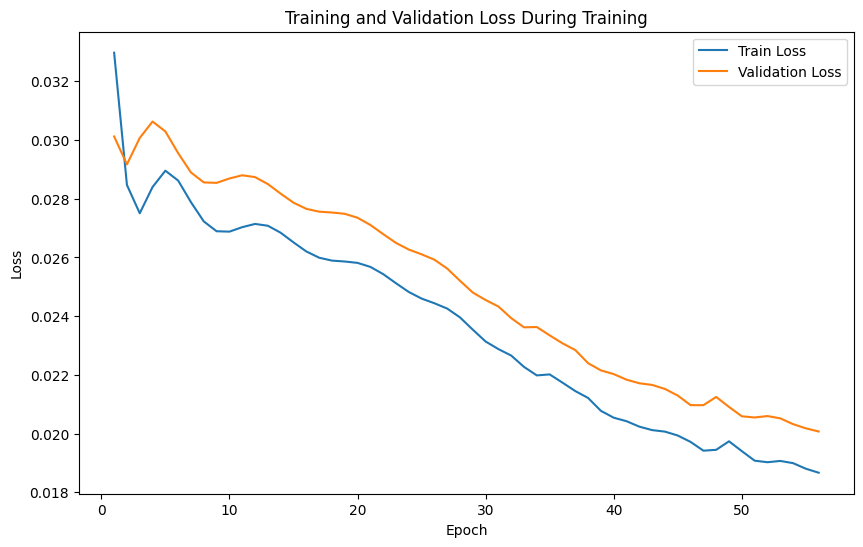

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Early stopping to stop training when validation loss doesn't improve.
        Args:
        patience (int): How long to wait after last time validation loss improved.
                        Default: 5
        min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize the model, loss, optimizer, and early stopping
input_size = 1
hidden_size = 64
output_size = 1
num_epochs = 100
learning_rate = 0.001

model = JordanRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
criterion2 = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

early_stopping = EarlyStopping(patience=10, min_delta=0.001)

import matplotlib.pyplot as plt

# Initialize lists to store the losses
train_losses = []
val_losses = []

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass for training
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Store the training loss
    train_losses.append(loss.item())

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    
    # Store the validation loss
    val_losses.append(val_loss.item())

    # Early stopping check
    early_stopping(val_loss.item())
    if early_stopping.early_stop and epoch > 50:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss During Training')
plt.legend()
plt.show()


In [11]:
# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 0.0187


In [12]:
# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion2(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 0.1100


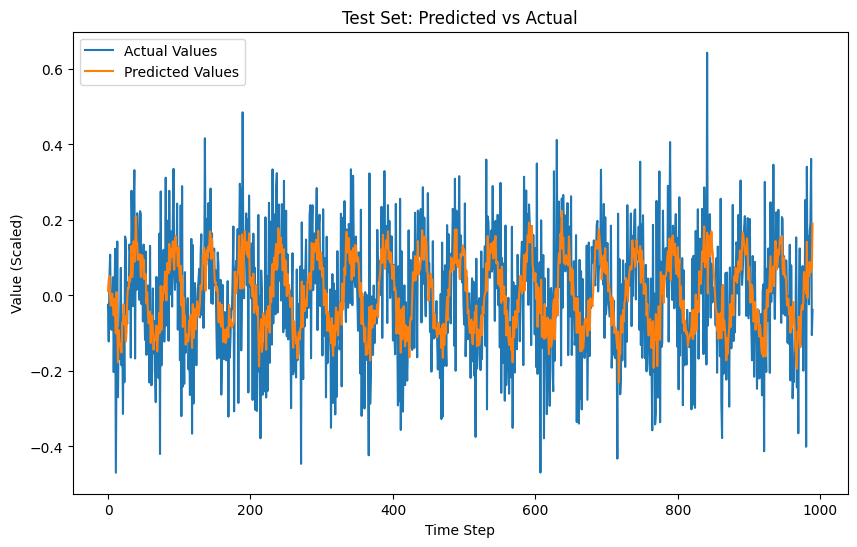

In [13]:
import matplotlib.pyplot as plt
# Plot predicted vs actual values
predicted_test = test_outputs.squeeze().numpy()
actual_test = y_test_tensor.numpy()

plt.figure(figsize=(10, 6))
plt.plot(actual_test, label='Actual Values')
plt.plot(predicted_test, label='Predicted Values')
plt.title('Test Set: Predicted vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Value (Scaled)')
plt.legend()
plt.show()


In [12]:
predicted_test

array([ 4.49882895e-02,  7.25816488e-02,  8.77915621e-02,  1.55875031e-02,
       -1.25694070e-02,  1.48988646e-02,  5.48389554e-03, -2.67067719e-02,
       -5.33366352e-02, -1.49770658e-02, -5.72871715e-02, -9.53236818e-02,
        1.60330329e-02, -8.07137713e-02, -1.73519313e-01, -7.25373924e-02,
       -1.03722177e-01, -9.89698917e-02, -9.95920449e-02, -1.11541487e-01,
       -2.92707589e-02, -3.49325761e-02, -1.73092540e-02, -8.78022537e-02,
       -9.13316011e-02, -1.51240155e-01, -1.17220804e-01, -2.36988254e-03,
        2.93151010e-02,  2.33846996e-02,  4.15737256e-02,  1.37093719e-02,
        2.73293462e-02,  8.64423066e-02, -2.09578685e-03,  3.27545404e-02,
        1.01981424e-01,  5.28101698e-02,  6.27839938e-02,  1.78863853e-01,
        9.96406451e-02,  9.21613574e-02,  5.49876392e-02,  5.35480976e-02,
        8.33637565e-02,  8.95020515e-02,  4.17506769e-02,  5.29225171e-02,
        1.16133869e-01,  8.19918960e-02,  9.15770456e-02,  3.65798995e-02,
        3.62089127e-02,  

In [13]:
actual_test

array([[-2.48160493e-02],
       [-1.21985011e-01],
       [ 4.71750610e-02],
       [ 1.07719883e-01],
       [-5.39881177e-02],
       [-9.13398862e-02],
       [-4.59423177e-02],
       [ 4.84031439e-02],
       [-2.03083917e-01],
       [-4.98180613e-02],
       [ 1.23439565e-01],
       [-4.69663620e-01],
       [-1.59284413e-01],
       [ 1.42777205e-01],
       [-2.69350082e-01],
       [-8.74728933e-02],
       [-1.68211758e-01],
       [-6.62355870e-02],
       [ 7.29103610e-02],
       [-1.85303539e-01],
       [-9.06936005e-02],
       [-3.14031452e-01],
       [-4.77710366e-02],
       [-2.29959399e-01],
       [ 1.55910939e-01],
       [ 1.44431606e-01],
       [-6.07311986e-02],
       [-7.48843327e-02],
       [ 3.46480571e-02],
       [-3.63674313e-02],
       [ 1.34773538e-01],
       [ 1.15954168e-01],
       [-1.64813697e-01],
       [ 2.77310967e-01],
       [ 1.60109490e-01],
       [-2.83455979e-02],
       [ 2.25917920e-01],
       [ 3.31890792e-01],
       [-1.6